In [12]:
!pip install scikit-image

     --------------------------------------- 12.2/12.2 MB 16.8 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 8.9 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 9.3 MB/s eta 0:00:00
     -------------------------------------- 210.3/210.3 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 42.2/42.2 MB 5.0 MB/s eta 0:00:00


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from skimage import exposure

from tensorflow.keras.datasets import cifar10
from tensorflow.data import Dataset

In [3]:
sns.set(rc={'figure.dpi': 120})
sns.set_style('whitegrid')

## Exploratory Data Analysis

In [4]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 33s 0us/step


In [5]:
print(f'Train image shape: {train_images.shape}')
print(f'Test image shape: {test_images.shape}')

Train image shape: (50000, 32, 32, 3)
Test image shape: (10000, 32, 32, 3)


In [6]:
n_labels = len(np.unique(train_labels))
print(f'Number of labels: {n_labels}')

Number of labels: 10


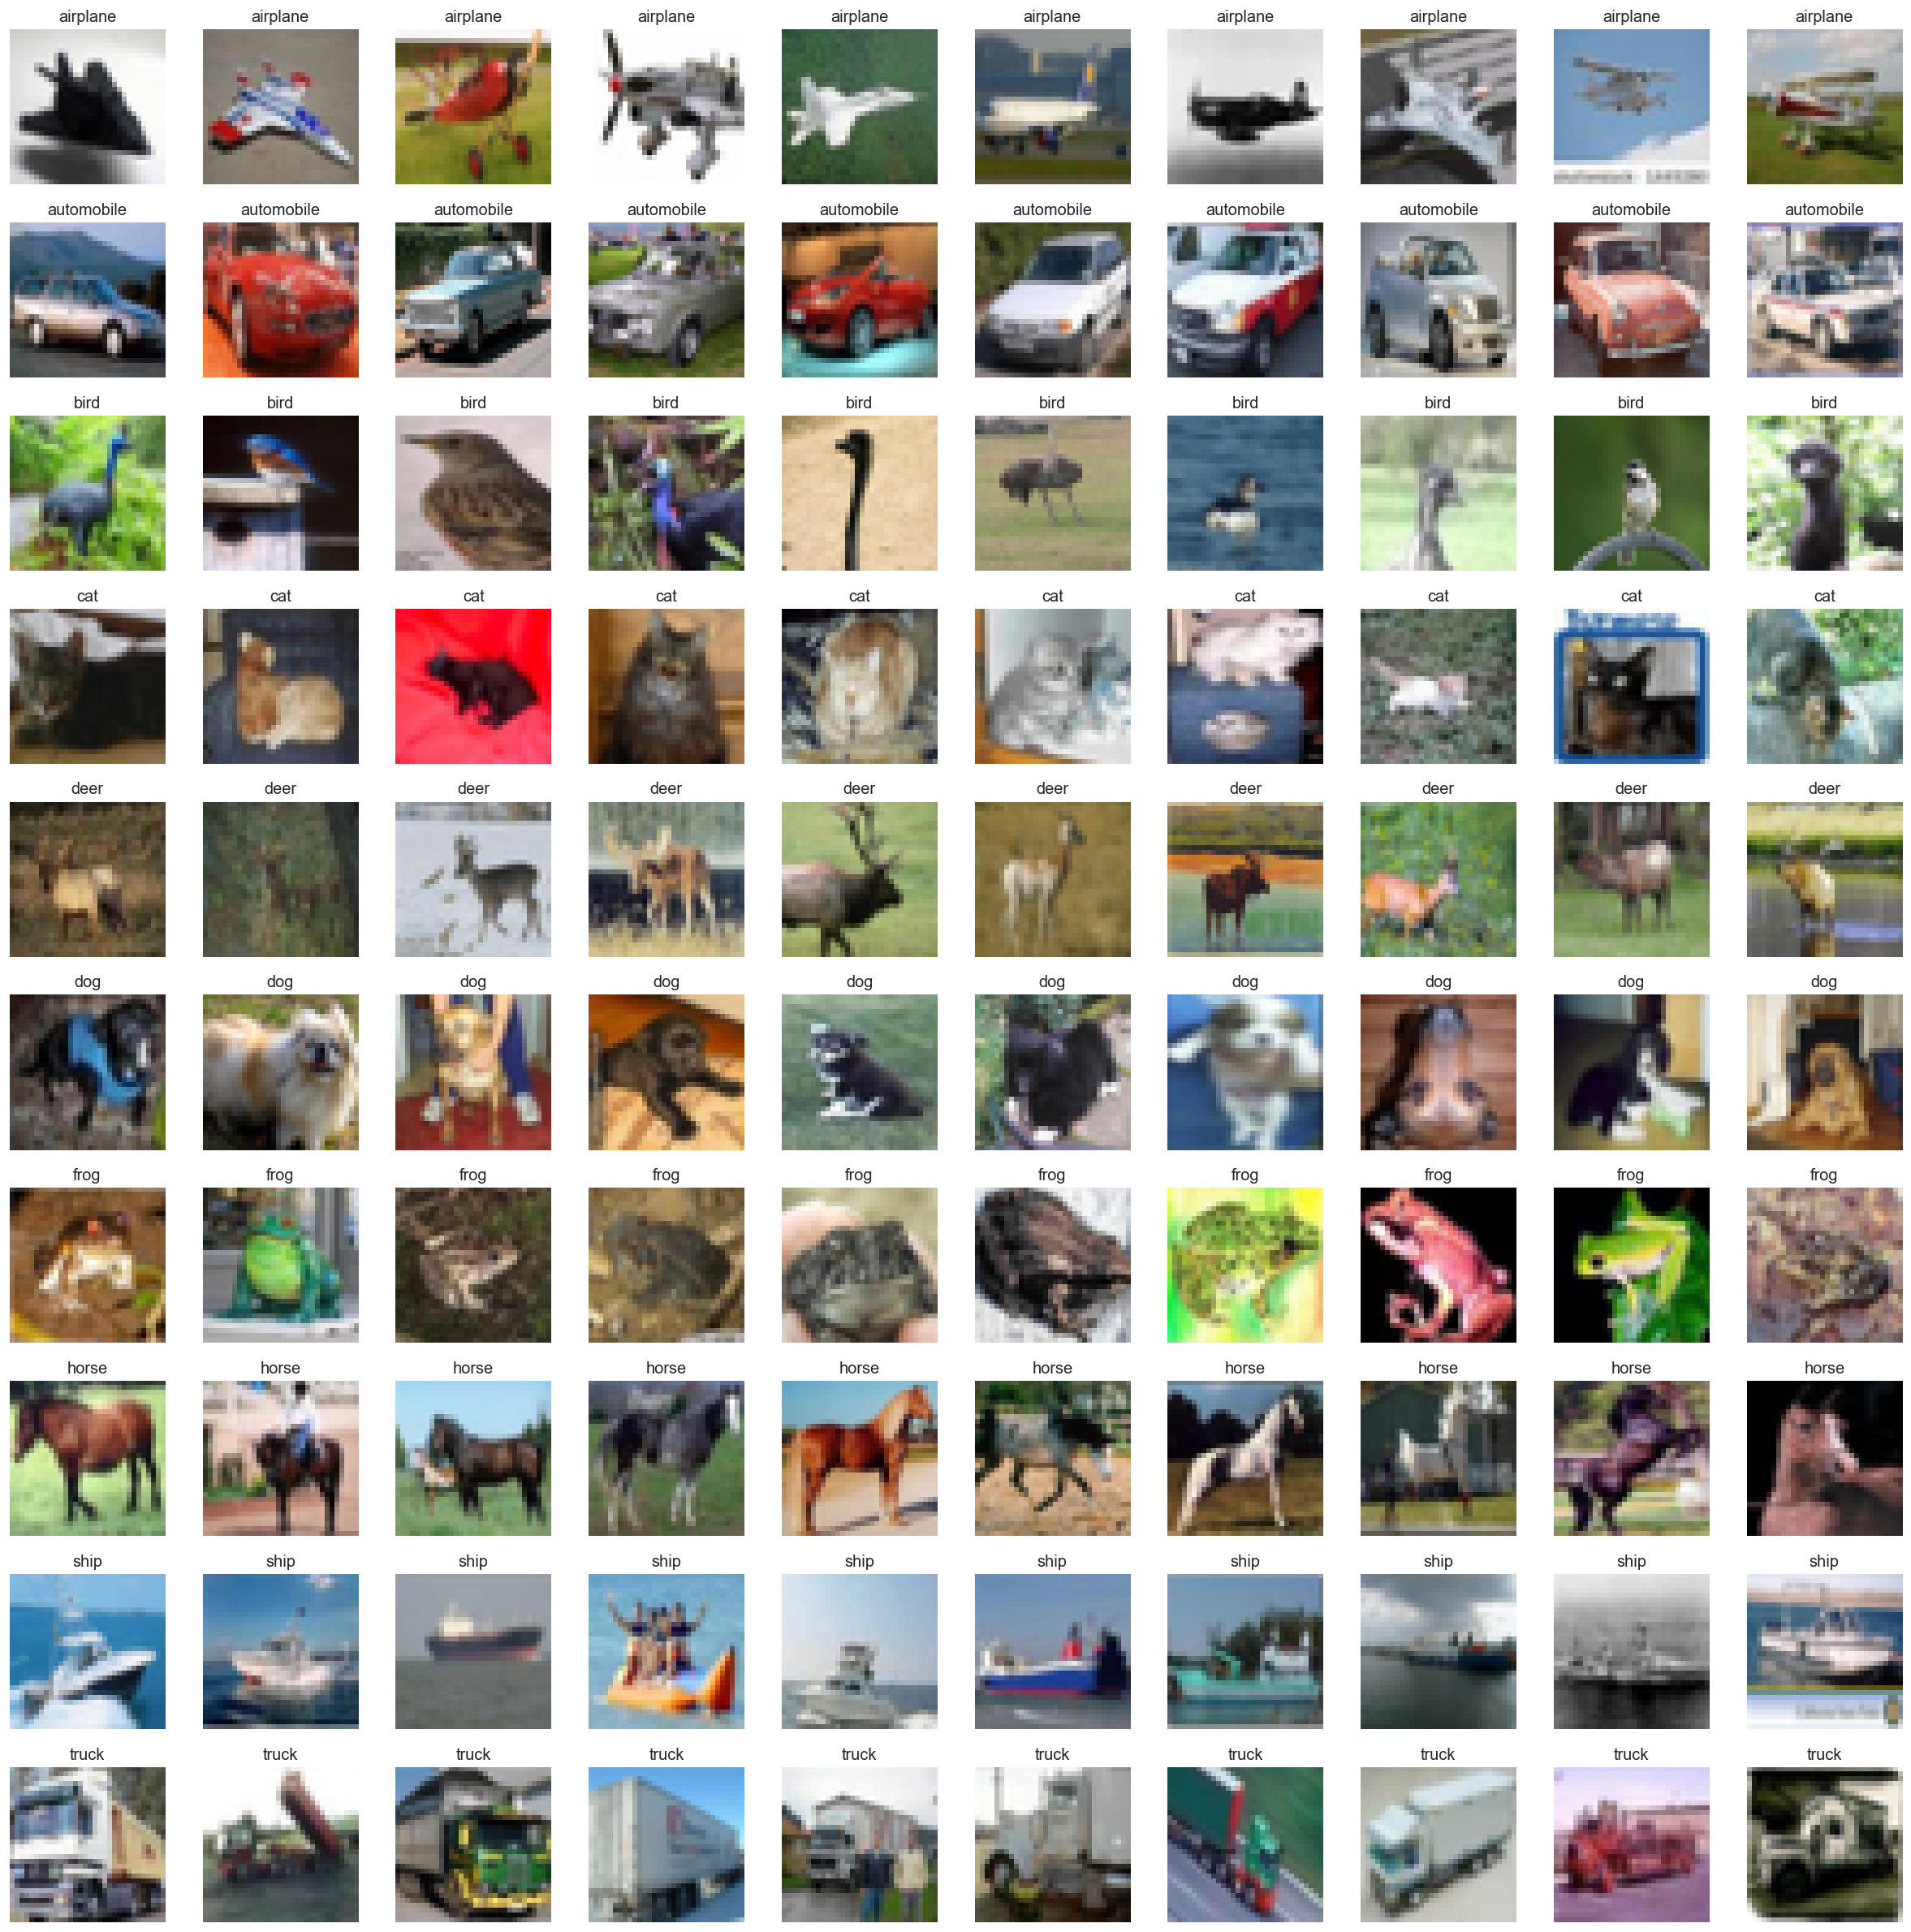

In [7]:
label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def display_images(images, labels, n_images=10):
    fig, axes = plt.subplots(nrows=n_labels, ncols=n_images, figsize=(20, 20))
    for i in range(n_images):
        for j in range(n_labels):
            axes[j, i].imshow(images[labels.flatten() == j][i])
            axes[j, i].set_title(label_map[j])
            axes[j, i].axis('off')
    plt.tight_layout()
    plt.show()

display_images(train_images, train_labels)

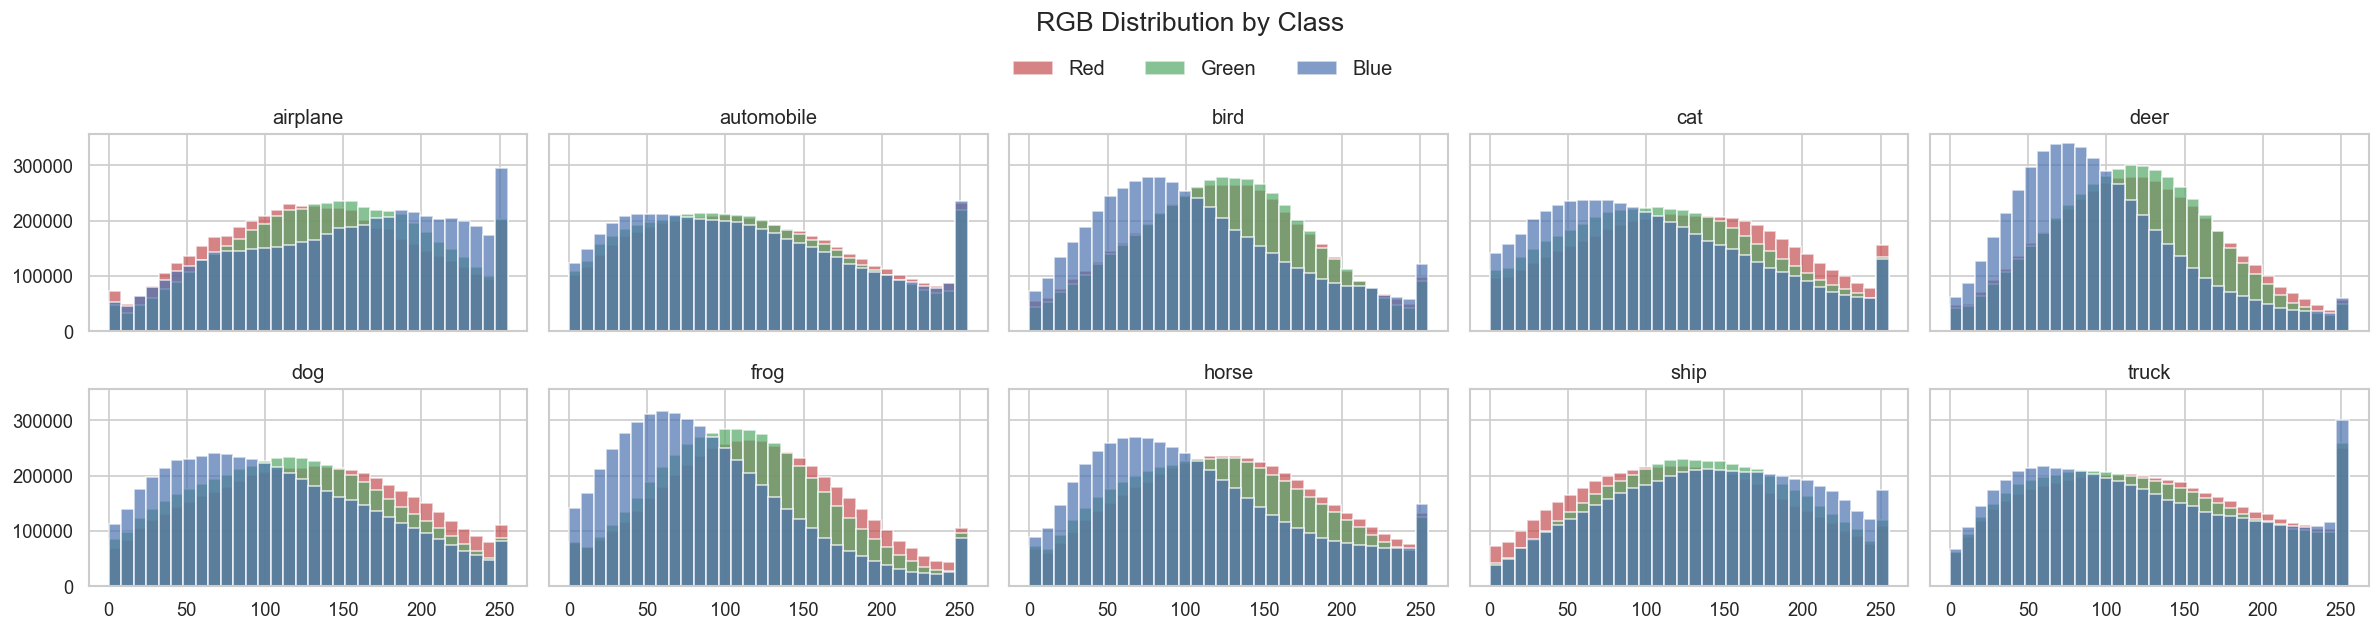

In [8]:
bins = 32

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 5), sharex=True, sharey=True)

for i, ax in zip(range(n_labels), axes.flat):
    idx = np.where(train_labels == i)[0]
    ax.hist(train_images[idx, ..., 0].ravel(), bins=bins, color='r', alpha=.7)
    ax.hist(train_images[idx, ..., 1].ravel(), bins=bins, color='g', alpha=.7)
    ax.hist(train_images[idx, ..., 2].ravel(), bins=bins, color='b', alpha=.7)
    ax.set_title(label_map[i])

fig.legend(['Red', 'Green', 'Blue'], loc='upper right', fontsize=12, ncol=3, bbox_to_anchor=(0.592, 1.0), frameon=False)
fig.suptitle('RGB Distribution by Class', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## Data Preparation

In [9]:
# concate train and test numpy arrays
images = np.concatenate((train_images, test_images), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

In [14]:
low_contrast_idx = []

for idx, image in enumerate(images):
    if exposure.is_low_contrast(image, fraction_threshold=0.15):
        low_contrast_idx.append(idx)

print(f'Number of low contrast images: {len(low_contrast_idx)}')

Number of low contrast images: 263


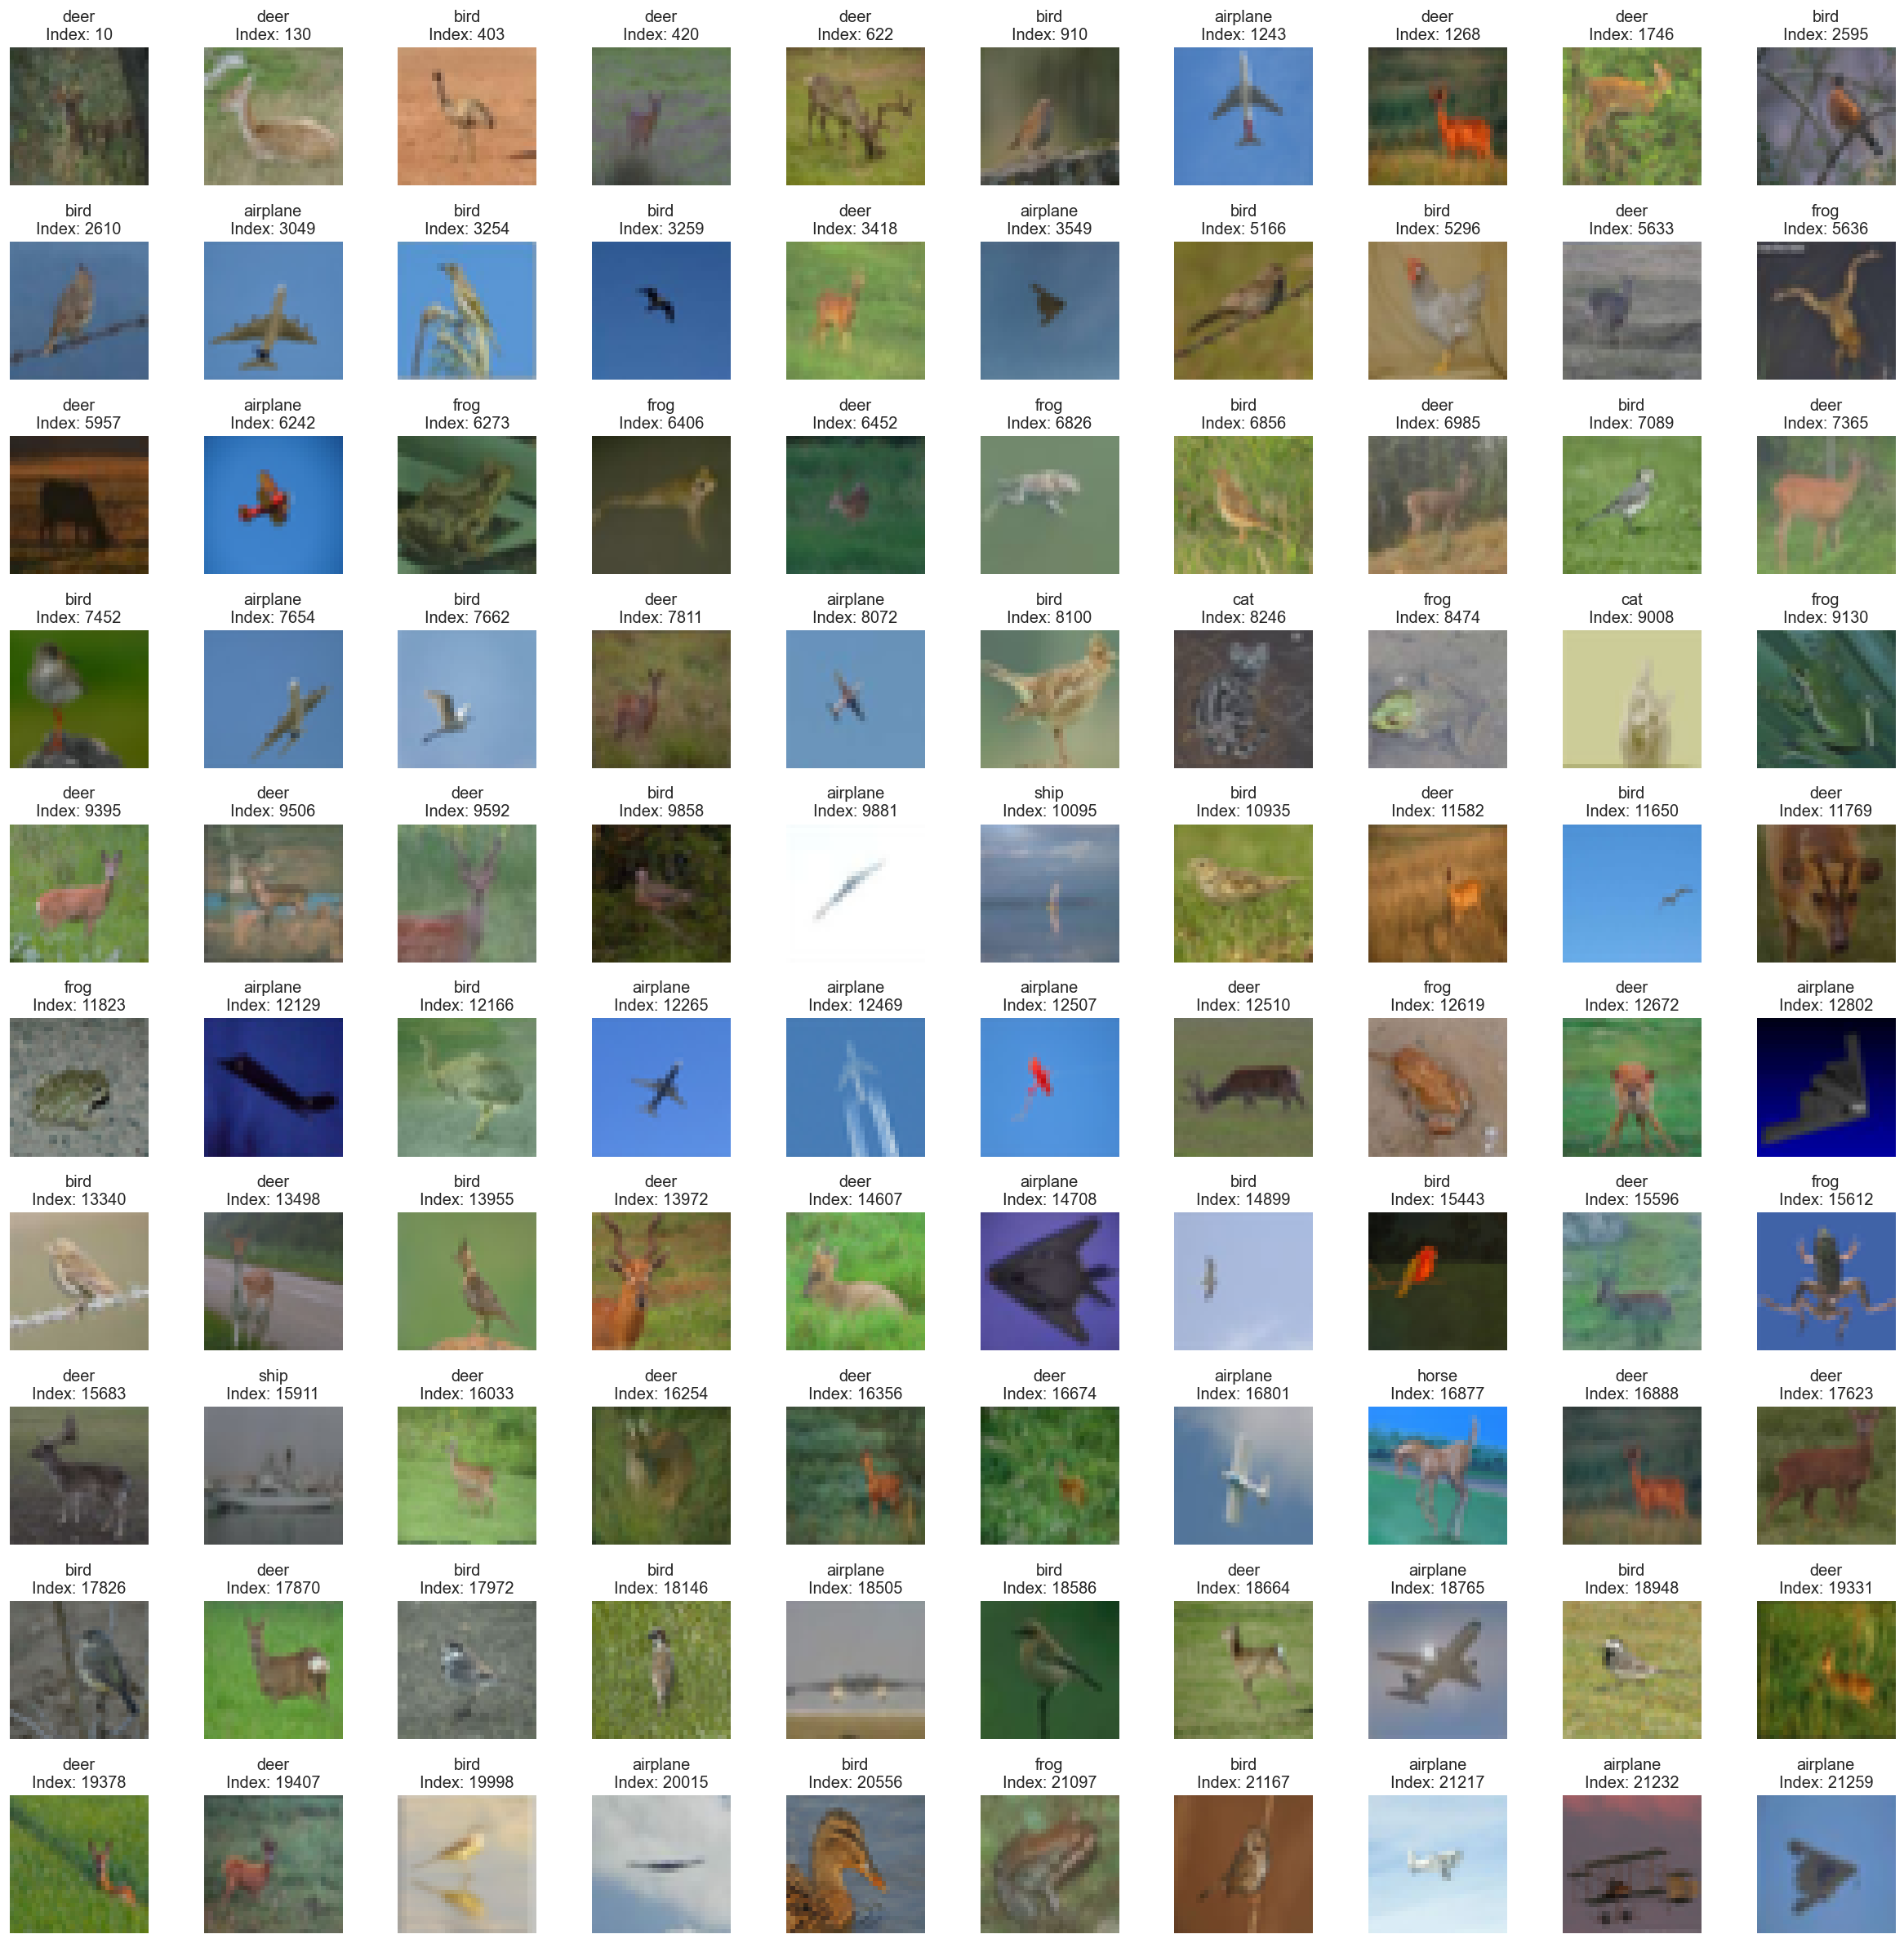

In [15]:
# plot images in the low contrast list
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for i in range(100):
    img_lbl = label_map[labels[low_contrast_idx[i]][0]]
    axes[i].imshow(images[low_contrast_idx[i]])
    axes[i].set_title(f'{img_lbl}\nIndex: {low_contrast_idx[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# delete low contrast images
images = np.delete(images, low_contrast_idx, axis=0)
labels = np.delete(labels, low_contrast_idx, axis=0)

print(f'New image shape: {images.shape}')
print(f'New label shape: {labels.shape}')

New image shape: (59737, 32, 32, 3)
New label shape: (59737, 1)


In [17]:
BUFFER_SIZE = 10_000
BATCH_SIZE = 128

dataset = Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# normalize images to range [-1, 1] as generator will be using tanh activation
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 127.5 - 1, y))

image_spec, label_spec = dataset.element_spec 

print(type(image_spec))
print(image_spec)
print(label_spec)

<class 'tensorflow.python.framework.tensor_spec.TensorSpec'>
TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)
TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None)


In [18]:
for batch in dataset.take(1):
    image, label = batch
    print(f'Image shape: {image.shape}')
    print(f'Label shape: {label.shape}')

Image shape: (128, 32, 32, 3)
Label shape: (128, 1)


## Export Dataset

In [19]:
FILE_DIR = 'data/'
FILE_NAME = 'cifar10.tfrecords'

dataset.save(FILE_DIR + FILE_NAME)
print(f'Dataset saved to {FILE_DIR + FILE_NAME}')

Dataset saved to data/cifar10.tfrecords
